# Spectral (and variance) analysis: 
* Atlantic Advective Heat Transport in PW (monthly averages)
* stephanie leroux Ocean Next

----

## Part 1: compute and save spectral data 

In [72]:
#==========================================================
#   PARAMETERS
#==========================================================
# input data directory
diri = "/Users/leroux31/DATA/OCCIPUT_DATA/TRANSPORT/"

# prefix and suffix of file names
nami1 = "det_ORCA025.L75-OCCITENS."
nami2="_5d_diaptr" 

# variable name
varnam = "sophtadvatl"

# lat min/max to compute spectrum and plot:
latpltmin = -35.
latpltmax =  70.

# select a subset of members? 
# include members from ims to ime
ims = 1
ime = 49

# save sp data in netcdf
ncsave=True
diro = "/Users/leroux31/Desktop/"

#==========================================================
#   MODULES
#==========================================================

%matplotlib notebook
%matplotlib inline

import os, user, sys
import matplotlib.pyplot as plt
import math
import numpy as np
import xarray as xr

from datetime import datetime
import netCDF4

#from pylab import *
#import scipy.signal
import scipy.signal as signal


#==========================================================
#   FUNCTIONS
#==========================================================
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    Got from scipy-cookbook: http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    np.hanning, np.hamming, np.bartlett, np.blackman, np.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y




#==========================================================
#   READ AND PRE-PROCESS DATA
#==========================================================
# pre-load data
data = xr.open_mfdataset(diri+nami1+'*'+nami2+'.nc',concat_dim='members')[varnam]
lat  = xr.open_dataset(diri+nami1+'050'+nami2+'.nc')["nav_lat"]
data.shape

# look for indexes of latmin latmax
latminindx=np.argmin(np.abs(latpltmin-lat))
#print(int(latminindx))
#print(lat.isel(y=int(latminindx)))

latmaxindx=np.argmin(np.abs(latpltmax-lat))
#print(int(latmaxindx))
#print(lat.isel(y=int(latmaxindx)))

print('Selected Latitude range:')
print('from '+str(latpltmin)+' to '+str(latpltmax))
print(str(int(latmaxindx-latminindx+1))+' points')

# select data
dataselect = data.sel(y=slice(latminindx,latmaxindx),time_counter=slice('1961-01-01', '2015-12-31'),members=slice(ims,ime))
dataselect.shape
latselect = lat.sel(y=slice(latminindx,latmaxindx))

# compute seasonal cycle (average for each month and over all members)
data_seascycle = dataselect.groupby('time_counter.month').mean(axis=1).mean(axis=0)

# make xarray from repeated seasonal cycle (repeated in time to cover the entire length of the timeseries and all members)
# initialize the array
data_seascycle_rep = dataselect
data_seascycle_rep = data_seascycle_rep*0.

# fill in with seasonal cycle value for each month
for imo in range(0,12):
    indeximo = np.where(data_seascycle_rep['time_counter.month']==imo+1)
    data_seascycle_rep.values[:,indeximo,:]=data_seascycle.values[imo,:]
    
    
# remove seasonal cycle from data
dataselect_dsc = dataselect-data_seascycle_rep 

# compute intrinsic part
dataint = dataselect_dsc - dataselect_dsc.mean(axis=0)
# array
dataintARRAY = np.array(dataint)


#dataint.values[np.where(np.abs(dataint.values)<1.e-6)]=0.


#==========================================================
#   Compute spectra at each latitude (and apply smoothing)
#==========================================================

# nb of latitude points over which to compute the spectra
NLATtot = dataselect_dsc.shape[2]

# nb of members in the ensemble
NMB    = dataselect_dsc.shape[0]

# nb of points in time
seglen = dataselect_dsc.shape[1]

# type of spectrum result: True for density spectrum. False for power spectrum
spnorm = True

# pad timeseries with zeros on 2 times the number of points of the initial time series
NPADDING = 2

# type of window to compute the spectrum
winsp='boxcar'

# select an example member to compute the individual spectrum
nnmb = 2     

# smoothing:
# nb of points to include in the convolution for smoothing with qe.smooth and a smoothing window smwin) 
smoolen = 9  # even 
# type of smoothing window
smwin = 'hanning'
# nb of smoothing passes on EMEAN  sp
nbpassemean = NMB 

## ========================================================
# initialise output arrays:

#spectre of total signal (raw and smoothed)
HMSPtot       = dataselect_dsc.isel(members=1)  #np.zeros((seglen,NLATtot),dtype=float64)  
HMSPtot       = HMSPtot*0.
HMSPtotSM     = HMSPtot*0.

#spectre of intrinsic signal (raw and smoothed)
HMSPint       = HMSPtot*0.
HMSPintSM     = HMSPtot*0.

#spectre of EMEAN signal (raw and smoothed)
HMSPEMEAN     = HMSPtot*0.
HMSPEMEANSM   = HMSPtot*0.

#spectre of intrinsic signal from one example member (raw and smoothed)
HMSPintmbex   = HMSPtot*0.
HMSPintmbexSM = HMSPtot*0.

## ========================================================

if spnorm:   
    scaling='density'
else:
    scaling='spectrum'

# loop on latitudes    
for ilatselect in range(0,NLATtot,1):
    if ilatselect in range(0,550,50):
        print(ilatselect)
        
    ###################### EMEAN
    dat1 = np.array(dataselect_dsc.isel(y=ilatselect).mean(axis=0))
    fff, ppp = signal.periodogram(dat1, fs=1,  window=winsp,nfft=NPADDING*seglen,scaling=scaling)     
    
    # smoothing
    pppsmoothed = smooth(ppp,window_len=smoolen,window=smwin)[(smoolen/2):len(ppp)+(smoolen/2)] 
    
    for inbpass in range(1,nbpassemean):
        pppsmoothed = smooth(pppsmoothed,window_len=smoolen,window=smwin)[(smoolen/2):len(ppp)+(smoolen/2)] 
        
    # SAVE psd for this lat    
    HMSPEMEAN.values[:,ilatselect]    = ppp[1:]  
    HMSPEMEANSM.values[:,ilatselect]  = pppsmoothed[1:] 
    del(ppp,pppsmoothed,dat1)
       
    ##################### TOT signal (averaged over the members)
    # loop on MBS from 1 to NMB
    
    for icol in range(0,NMB):
        addmb     = np.array(dataselect_dsc.isel(y=ilatselect,members=icol))
        fff, ppp = signal.periodogram(addmb, fs=1,  window=winsp,nfft=NPADDING*seglen,scaling=scaling)
        if (icol==0):
            pppave   = ppp/NMB
        else:
            pppave   = pppave + ppp/NMB
    
    # smoothing    
    pppsmoothed = smooth(pppave,window_len=smoolen,window=smwin)[(smoolen/2):len(ppp)+(smoolen/2)]        
    
    for inbpass in range(1,nbpassemean):
        pppsmoothed = smooth(pppsmoothed,window_len=smoolen,window=smwin)[(smoolen/2):len(ppp)+(smoolen/2)]       
     
    
    # SAVE psd for this lat
    HMSPtot.values[:,ilatselect]     = pppave[1:]  
    HMSPtotSM.values[:,ilatselect]   = pppsmoothed[1:] 
    
    del(ppp,pppsmoothed,pppave,addmb)
 
    ###################### INT signal (averaged over the members)
    # loop on mbs from 1 to 50
    
    for icol in range(0,NMB):
        
        #addmb    =  np.array(dataint.isel(y=ilatselect,members=icol))
        addmb    = dataintARRAY[icol,:,ilatselect]
        fff, ppp = signal.periodogram(addmb, fs=1,  window=winsp,nfft=NPADDING*seglen,scaling=scaling)
        if (icol==0):
            pppave   = ppp/NMB
        else:
            pppave   = pppave + ppp/NMB
          
            
    # smoothing                
    pppsmoothed = smooth(pppave,window_len=smoolen,window=smwin)[(smoolen/2):len(ppp)+(smoolen/2)]    
    
    for inbpass in range(1,nbpassemean):
        pppsmoothed = smooth(pppsmoothed,window_len=smoolen,window=smwin)[(smoolen/2):len(ppp)+(smoolen/2)]       
    
    # SAVE psd for this lat
    HMSPint.values[:,ilatselect]     = pppave[1:]  
    HMSPintSM.values[:,ilatselect]   = pppsmoothed[1:]
    
    del(ppp,pppsmoothed,pppave,addmb)
   
    ####################### INT signal of one example member (# nnmb-1)
    # MB #nnmb
    #dat2 = np.array(dataint.isel(y=ilatselect,members=nnmb))
    dat2 = dataintARRAY[nnmb,:,ilatselect]
    fff, ppp    = signal.periodogram(dat2, fs=1,  window=winsp,nfft=NPADDING*seglen,scaling=scaling)
    
    # smoothing
    pppsmoothed = smooth(ppp,window_len=smoolen,window=smwin)[(smoolen/2):len(ppp)+(smoolen/2)]
    for inbpass in range(1,nbpassemean):
        pppsmoothed = smooth(pppsmoothed,window_len=smoolen,window=smwin)[(smoolen/2):len(ppp)+(smoolen/2)]        
     
    # SAVE psd for this lat
    HMSPintmbex.values[:,ilatselect]     = ppp[1:]  
    HMSPintmbexSM.values[:,ilatselect]   = pppsmoothed[1:]
     
    del(ppp,pppsmoothed,dat2)

# compute ratio intr/emean (smoothed)
prera = (1./HMSPintSM)
ratio=HMSPEMEANSM*prera
ratio.shape

#==========================================================
#   SAVE IN NETCDF
#==========================================================
if ncsave:
    #spectre of total signal (raw and smoothed)
    HMSPtot.to_dataset().to_netcdf(diro+'HMSPtot.nc')
    HMSPtotSM.to_dataset().to_netcdf(diro+'HMSPtotSM.nc')

    #spectre of intrinsic signal (raw and smoothed)
    HMSPint.to_dataset().to_netcdf(diro+'HMSPint.nc')
    HMSPintSM.to_dataset().to_netcdf(diro+'HMSPintSM.nc')

    #spectre of EMEAN signal (raw and smoothed)
    HMSPEMEAN.to_dataset().to_netcdf(diro+'HMSPEMEAN.nc')
    HMSPEMEANSM.to_dataset().to_netcdf(diro+'HMSPEMEANSM.nc')

    #spectre of intrinsic signal from one example member (raw and smoothed)
    HMSPintmbex.to_dataset().to_netcdf(diro+'HMSPintmbex.nc')
    HMSPintmbexSM.to_dataset().to_netcdf(diro+'HMSPintmbexSM.nc')
    

Selected Latitude range:
from -35.0 to 70.0
510 points
0
50
100
150
200
250
300
350
400
450
500


## Part 2: Plots

In [7]:
from  matplotlib import *
from matplotlib import mlab
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.dates as mdates

import Ngl  # not necessary but then you have to use other color maps (see below)s


### - READ saved data

In [9]:
# read saved data

HMSPtot       = xr.open_dataset(diro+'HMSPtot.nc')["sophtadvatl"]
HMSPtotSM     = xr.open_dataset(diro+'HMSPtotSM.nc')["sophtadvatl"]

#spectre of intrinsic signal (raw and smoothed)
HMSPint       = xr.open_dataset(diro+'HMSPint.nc')["sophtadvatl"]
HMSPintSM     = xr.open_dataset(diro+'HMSPintSM.nc')["sophtadvatl"]

#spectre of EMEAN signal (raw and smoothed)
HMSPEMEAN     = xr.open_dataset(diro+'HMSPEMEAN.nc')["sophtadvatl"]
HMSPEMEANSM   = xr.open_dataset(diro+'HMSPEMEANSM.nc')["sophtadvatl"]

#spectre of intrinsic signal from one example member (raw and smoothed)
HMSPintmbex   = xr.open_dataset(diro+'HMSPintmbex.nc')["sophtadvatl"]
HMSPintmbexSM = xr.open_dataset(diro+'HMSPintmbexSM.nc')["sophtadvatl"]

### - Prepare same colormap as for AMOC paper
Via Ngl.
Could also just use some matplotlib colormaps instead

In [13]:
pltty="pdf"
ptslats = latselect   
import cmocean
rlist = Ngl.Resources()
rlist.wkColorMap ="BkBlAqGrYeOrReViWh200"
wks = Ngl.open_wks("x11","example",rlist)
fromncl = Ngl.get_MDfloat_array(wks,"wkColorMap")


rlist2 = Ngl.Resources()
rlist2.wkColorMap = "WhiteBlueGreenYellowRed"
wks2 = Ngl.open_wks("x11","example",rlist2)
fromncl2 = Ngl.get_MDfloat_array(wks2,"wkColorMap")


cmap = cm.Spectral
cmap2 = cm.Spectral


### - log(sp) for emean or int or tot (+ optional ratio)


/Users/leroux31/anaconda2/envs/newwthNCL/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in divide
/Users/leroux31/anaconda2/envs/newwthNCL/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in divide


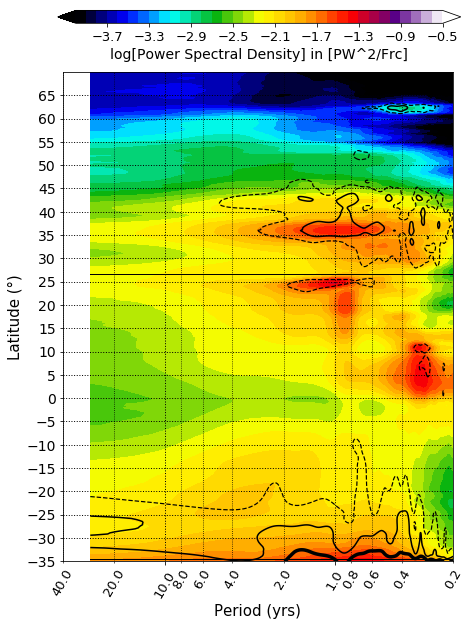

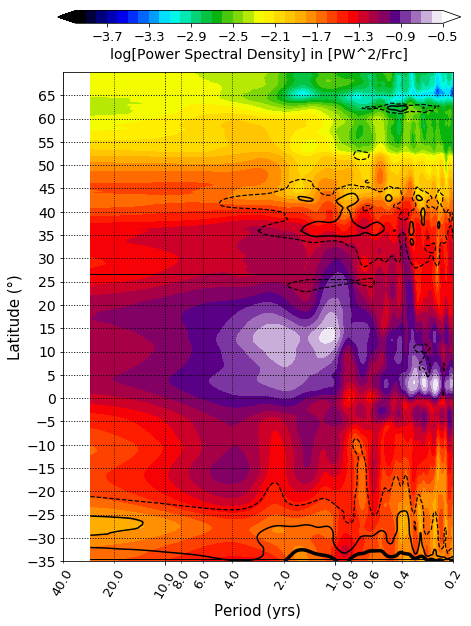

In [16]:
### choose below:
varchoice = (0,1)  ### 0: "int", 1:"EMEAN", 2:"tot")
smoo = True        ### plot smoothed data or not
addratioc=True     ### add contours for ratio
###


# compute ratio intr/emean (smoothed)
prera = (1./HMSPintSM)
ratio=HMSPEMEANSM*prera
ratio.shape



ptslats=latselect
suffix="test"
pltty="pdf"

# frequency range to plot
nff = ( np.abs((1./(12.*fff))-28.)).argmin()  # max frequency to plot (half the total length of the timeseries, i.e. 28 yrs)

nff2 = ( np.abs((1./(12.*fff))-0.2)).argmin() # min frequency to plot (twice the timeseries frequency: 2mo (~0.2 yr))


varoptions = ("int","EMEAN","tot")

### choose below:
varchoice = (0,1)
smoo = True
addratioc=True
###
    
plt.close('all')   
for ivarc in varchoice:
    if smoo:
        namprint = varoptions[ivarc]+"SM"
    else:
        namprint = varoptions[ivarc]
        
    plt.close('all') 
    if addratioc:
        namefig = "4ALLLATSP_"+namprint+"_"+suffix+"_SMmultipass"+str(smoolen)+"_SP"+scaling+".wthR."+pltty 
    else:
        namefig = "4ALLLATSP_"+namprint+"_"+suffix+"_SMmultipass"+str(smoolen)+"_SP"+scaling+"."+pltty    
        
    if namprint=="intSM":
        Z = np.log10((HMSPintSM.values[nff-1:nff2-1,:]).T)
    if namprint=="int":
        Z = np.log10((HMSPint.values[nff-1:nff2-1,:]).T)
    if namprint=="EMEANSM":
        Z = np.log10((HMSPEMEANSM.values[nff-1:nff2-1,:]).T)
    if namprint=="EMEAN":
        Z = np.log10((HMSPEMEAN.values[nff-1:nff2-1,:]).T)
    if namprint=="totSM":
        Z = np.log10((HMSPtotSM.values[nff-1:nff2-1,:]).T)
    if namprint=="tot":
        Z = np.log10((HMSPtot.values[nff-1:nff2-1,:]).T)
       

    if addratioc:
        ZR = 10.*np.log10((ratio.values[nff-1:nff2-1,:]).T)
    
    fig1 = plt.figure(figsize=([7,9]),facecolor='white')  
    X = (12.*fff[nff:nff2])
    Y = ptslats
    testcmap=cmap.from_list('fromncl', fromncl)


    if spnorm:    
        # density:        
        cs=plt.contourf(X,Y,Z,levels=np.arange(-4., -0.4, 0.1),cmap=testcmap,extend="both")  
    else:
        #spectrum
        cs=plt.contourf(X,Y,Z,levels=np.arange(-5.0, -1.2, 0.1),cmap=testcmap,extend="both") 

    if addratioc:
        fmt = {}
        #clabelsstr=['140%','100%','70%','50%']
        clabelsstr=['','','','']
        levels = [-10.,0.,3.,6.]
        cs2=plt.contour(X,Y,ZR,levels,colors=['k','k','k','k'],linewidths=[3.5,3.5,1.5,1.2],linestyles=['-','-','-','--'])
        for l,s in zip( cs2.levels, clabelsstr ):
            fmt[l] = s
          
        
        
    cs.cmap.set_under('black')
    plt.plot([X[0],X[len(X)-1]],[26.6,26.6],color="k",linewidth=1)
    plt.plot([X[0],X[len(X)-1]],[-34.5,-34.5],color="k",linewidth=1)
    #plt.plot([X[0],X[len(X)-1]],[0,0],color="k",linewidth=1,linestyle=":")

    plt.ylabel(u"Latitude (\u00B0)")
    plt.xlabel('Period (yrs)')
    plt.ylim( -35, 70 )

    ax = plt.gca()    
    plt.tick_params(axis="both", which="both", bottom="on", top="on",  
                labelbottom="on",labeltop="on", left="on", right="on", labelleft="on")          
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 
    ax.yaxis.grid(color="k",linewidth=1,linestyle=":") 
    ax.xaxis.grid(color="k",linewidth=1,linestyle=":")
    ax.set_xscale('log')
    ax.set_yticks(np.arange(-35,70,5))
    ax.yaxis.label.set_size(15)
    ax.xaxis.label.set_size(15)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    cbaxes = fig1.add_axes([0.115, 0.955, 0.8, 0.02]) 
    
    cbar=plt.colorbar(cs,orientation='horizontal', cax = cbaxes,label='log')
    
    if spnorm:    
        # density:
        cbar.set_label(r"log[Power Spectral Density] in [PW^2/Frc]", size=14)
    if spnorm==False:    
        # spectrum:        
        cbar.set_label(r"log[Power Spectrum] in [PW^2]", size=14)
    cbar.ax.tick_params(labelsize=13) 

    # from Guillaume Sérazin
    ax.set_xscale('log', nonposx='clip')
    xmin = np.ceil(np.log10(np.abs(X[1,]))) - 1
    xmax = np.ceil(np.log10(np.abs(X[-1,])))

    new_major_ticks = 10 ** np.arange(xmin + 1, xmax, 1)
    new_major_ticklabels = (1. / new_major_ticks)
    A = np.arange(2, 10, 2)[np.newaxis]
    B = 10 ** (np.arange(-xmax, -xmin, 1)[np.newaxis])
    C = np.dot(B.transpose(), A)
    new_minor_ticklabels = C.flatten()[:10]
    new_minor_ticks = 1. / new_minor_ticklabels

    ax.set_xticks(new_major_ticks)
    ax.set_xticklabels(new_major_ticklabels,rotation=60, fontsize=13)
    ax.set_xticks(new_minor_ticks, minor=True)
    ax.set_xticklabels(new_minor_ticklabels, minor=True,rotation=60, fontsize=13)
    ax.grid(True, which='both',linestyle=":",color="k")

    plt.show()
    fig1.savefig(diro+namefig, facecolor=fig1.get_facecolor(), edgecolor='none')
plt.close('all')       

#### Caption of the 2 plots above:

CAPTION: Power Spectral Density (PSD) on a log$_{10}$-scale  in PW$^{2}$.frq$^{-1}$,  as a function of latitude in ENSx50-occi025,  from:  (a) the 56-year-long ensemble-mean monthly  timeseries of the Atlantic Advective Heat Transport (PSD$_{Forced}$), and (b) 50$\times$ 56-yrs intrinsic monthly timeseries  (PSD$_{Intrinsic}$). The ratio of the the two PSDs is also computed as $R_{PSD}=10\times\log\left[PSD_{Forced}/PSD_{Intrinsic}\right]$ (in dB), and contours are shown on the two panels for ratio values of  -6, -3 and 0 dB (thin-dashed, medium and thick black contours, respectively) translating to an amplitude of the intrinsic variability  of   50\%, 70\% and 100\% of the forced variability, respectively.

### ========================================================================================

## Variance (and STD)-latitude profile

In [27]:
################################################
# FUNCTION DEFS
################################################    

def tick_function(Y):
    V = np.sqrt(Y)
    return ["%.2f" % z for z in V]

### - Prepare variables to plot

In [65]:
# STD or VAR plot ?
statchoice = "var"  # "std" "var" #stdbis
annual = True  # plot from annual means or monthly means?

# set degree of freedom depending on the size of the ensemble 
if (NMB < 15):                    
    ddof=0
else :
    ddof=1

if annual:
    dataannual = dataselect_dsc.groupby('time_counter.year').mean(axis=1)
    pltname1 = "varplt_annual_"
    TSTDEMEAN = dataannual.mean(axis=0).std(axis=0,ddof=ddof)
    TVAREMEAN = dataannual.mean(axis=0).var(axis=0,ddof=ddof)

    ESTDMB    = dataannual.std(axis=0,ddof=ddof).mean(axis=0)
    EVARMB    = dataannual.var(axis=0,ddof=ddof).mean(axis=0)

    TSTDMB    = dataannual.std(axis=1,ddof=ddof)
    TVARMB    = dataannual.var(axis=1,ddof=ddof)       

else:
    pltname1 = "varplt_monthly_"
    TSTDEMEAN = dataselect_dsc.mean(axis=0).std(axis=0,ddof=ddof)
    TVAREMEAN = dataselect_dsc.mean(axis=0).var(axis=0,ddof=ddof)

    ESTDMB    = dataselect_dsc.std(axis=0,ddof=ddof).mean(axis=0)
    EVARMB    = dataselect_dsc.var(axis=0,ddof=ddof).mean(axis=0)

    TSTDMB    = dataselect_dsc.std(axis=1,ddof=ddof)
    TVARMB    = dataselect_dsc.var(axis=1,ddof=ddof)       

       

### - Plot

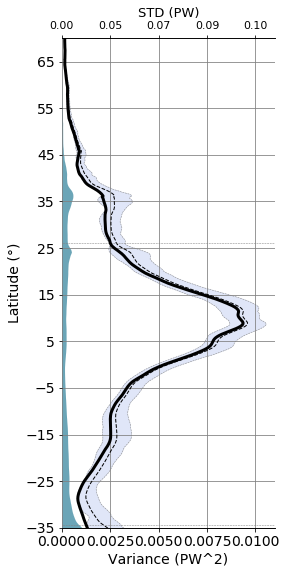

In [70]:

# Plot either var or std stats
if statchoice=="var":
    ESTDMBpl = EVARMB
    TSTDMBpl = TVARMB
    TSTDEMEANpl = TVAREMEAN
elif statchoice=="std":
    ESTDMBpl = ESTDMB
    TSTDMBpl = TSTDMB
    TSTDEMEANpl = TSTDEMEAN
else :
    ESTDMBpl = np.sqrt(EVARMB)
    TSTDMBpl = TSTDMB
    TSTDEMEANpl = TSTDEMEAN
    

# output name    
suffix = ""

if statchoice=="var":
    prefix="latprofileVAR"
elif statchoice=="std":
    prefix="latprofileSTD"
else:
    prefix="latprofileSTDBIS"   




#========================================================
#========================================================
#===  LAT PROFILE 
#========================================================    
rcParams.update({'figure.autolayout' : False})
rcParams.update({'figure.subplot.top' : 0.93})
rcParams.update({'figure.subplot.bottom' : 0.08})
rcParams.update({'figure.subplot.right' : 0.95})
rcParams.update({'figure.subplot.left' : 0.21})

if statchoice=="var":
    maxamp = 0.011  # A 
else:
    maxamp = 0.01  # A or filt 2yr
    
       
plt.close('all')  
fig1 = plt.figure(figsize=([4,8]),facecolor='white')  #A9D0F5

plt.fill(np.append(TSTDMBpl.max(axis=0),TSTDMBpl.min(axis=0)[::-1]),np.append(ptslats,ptslats[::-1]),color="#E0E6F8",linewidth=0.5)
plt.fill(np.append(ESTDMBpl,ESTDMBpl[::-1]*0.0),np.append(ptslats,ptslats[::-1]),color="#086A87",alpha=0.6,linewidth=0.1)

plt.plot(TSTDMBpl.min(axis=0),ptslats,color="#848484",linewidth=0.5,linestyle="--")
plt.plot(TSTDMBpl.max(axis=0),ptslats,color="#848484",linewidth=0.5,linestyle="--")
plt.plot(TSTDMBpl.mean(axis=0),ptslats,color="k",linewidth=1.0,linestyle="--")

plt.fill(TSTDEMEANpl[0]*0.,ptslats[0],color="#086A87",alpha=0.6,label="Chaotic variability",linewidth=5,zorder=6)
plt.plot(TSTDEMEANpl,ptslats,color="k",label="Forced variability",linewidth=3,zorder=4) #facc2e
plt.fill(TSTDMBpl.mean(axis=0)[0]*0.,ptslats[0],color="#E0E6F8",linewidth=3,label="Time-variance of mbs",zorder=5)

plt.plot([-100.,100.],[26.,26.],color="grey",linewidth=0.5,linestyle='--')
plt.plot([-100.,100.],[-34.5,-34.5],color="grey",linewidth=0.5,linestyle='--')
plt.ylim( -35, 70 )
plt.xlim( 0, maxamp )
ax = plt.gca()    

# Remove the plot frame lines. They are unnecessary chartjunk.  
ax.spines["top"].set_visible(True)  
ax.spines["bottom"].set_visible(True)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)  

ax.get_xaxis().tick_top() 
ax.get_xaxis().tick_bottom()  
#ax.get_yaxis().tick_left() 
ax.get_yaxis().tick_right()
ax.yaxis.grid(color="grey") 
ax.xaxis.grid(color="grey")
ax.set_yticks(np.arange(-35,70,10))
ax.yaxis.label.set_size(14)
ax.xaxis.label.set_size(14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')

plt.ylabel(u"Latitude (\u00B0)")

ax.yaxis.set_label_position("left")
plt.tick_params(axis="both", which="both", bottom="on", top="on",  
        labelbottom="on", left="on", right="off", labelright="off",labelleft="on")  


if statchoice=="var":
    plt.xlabel('Variance (PW^2)')
else:
    plt.xlabel('(PW)')
    
    
ax2 = ax.twiny()
ax2.xaxis.set_label_position("top") 
ax2.get_xaxis().tick_top() 
ax.get_xaxis().tick_bottom() 
ax1Ticks = ax.get_xticks()   
ax2Ticks = ax1Ticks
ax2.set_xticks(ax2Ticks)
ax2.set_xbound(ax.get_xbound())
ax2.set_xticklabels(tick_function(ax2Ticks))
ax2.get_xaxis().set_tick_params(direction='out')

ax2.set_xlabel('STD (PW)', color='k')

ax2.tick_params('x', colors='k')
ax2.xaxis.label.set_size(13)
ax2.xaxis.set_tick_params(labelsize=11)

ax2.spines["top"].set_visible(True)  
ax2.spines["bottom"].set_visible(True)  
ax2.spines["right"].set_visible(False)  
ax2.spines["left"].set_visible(False)      
    
    
plt.legend(bbox_to_anchor=(0.3, 0.88, 0.9, -0.5), loc=3,
           ncol=1, mode="expand", borderaxespad=0.3,frameon=False)  

plt.show()   
fig1.savefig(diro+prefix+"."+pltname1+"."+suffix+"."+pltty, facecolor=fig1.get_facecolor(), edgecolor='none')


CAPTION of the plot above (similar definitions as in AMOC paper):

Intrinsic and forced components of interannual heat transport variance ($A^{2}_{intrinsic}$ in blue shading and $A^{2}_{forced}$ in thick black line, respectively)   as a function of latitude from ENSx50-occi025, detrended, over 1961-2015. The distribution of the total temporal variability in each member is shown with dashed lines ($Min(A^{2}_{tot,i})$, $<A^{2}_{tot,i}>$, $Max(A^{2}_{tot,i})$) and light blue shading. Note that tickmarks  are provided on a square-root scale on the top x-axis, in order to read more easily the standard-deviation values corresponding to the plotted variances. Tickmarks on a linear scale are on the bottom x-axis.